In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

from jax import lax,ops
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

from LeapfrogJAX import LP
from TrainingDataJAX import GenerateTrainingData
from NewtonLAX import NewtonLAX
from ShadowMP1d import GPMP
from CompareContours import *

# for comparision of LSI to other approaches

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from skopt.space import Space
from skopt.sampler import Halton

from VariationalMP import VarMPIntegrator
from GPEL import GPEL

## Training data generation

In [2]:
# setup problem for generation of training data
f = lambda x: -jnp.sin(x)

H = lambda y: 1/2*y[1]**2 - jnp.cos(y[0])
H_ref = lambda y: 1/2*y[1]**2 - jnp.cos(y[0])

h = 0.5
spacedim=[(-jnp.pi, jnp.pi), (-1.2, 1.2)]
n_train = 400
n_train_length = 5

In [3]:
# generate training data using Verlet integration with n_h intermediate steps
n_h=int(1e5)
data,DataPairs,DataTriples=GenerateTrainingData(spacedim,f,n_train,n_train_length,h,n_h)

In [4]:
# font size for plots
plt.rcParams.update({'font.size': 18})

Text(0, 0.5, '$\\dot{q}$')

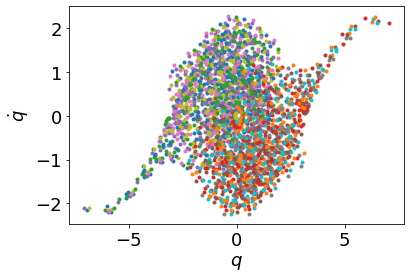

In [5]:
# plot of training data
# (!) the learning algorithm only sees the q-values (!)

for j in range(0,n_train):
    plt.plot(data[0][j],data[1][j],'.')

plt.xlabel('$q$')
plt.ylabel('$\dot{q}$')
#plt.savefig('PendulumTrainingData.pdf',bbox_inches='tight')

## Set up GP for LSI and learn the inverse modified Lagrangian

In [6]:
# define kernel function: use rbf

e      = 5.                                           # length scale
distsq = lambda x,y: jnp.sum((x-y)**2)
k      = lambda x,y: jnp.exp(-1/(e**2)*distsq(x,y))

In [7]:
# create instance of LSI process
gpmp=GPMP(k,h,DataPairs,DataTriples)

In [8]:
# train LSI instance
_,_,_=gpmp.train()

start training
calculate non-triviality condition
calculate data consistency equations
solve linear system dimensions: (1602, 2000)


In [9]:
# check residuum and rank of linear system of the training process
gpmp.res,gpmp.rank

(DeviceArray([8.59843596e-09], dtype=float64), DeviceArray(61, dtype=int64))

## compute trajectory

In [10]:
# initialise trajectory

q0 = jnp.array([0.3])
q0dot = jnp.array([0.])

n = 10000 # steps
t = h*jnp.arange(n+1)

In [11]:
# compute trajectory with Lagrangian shadow integration

trj,trj_phase,H2_trj,trj_ref = pickle.load(open( "data/PendulumMP10000_save.p", "rb" ) ) # load pre-computed data
#trj=gpmp.compute_motion(q0,q0dot,n)                                                     # uncomment for re-computation

In [12]:
# measure how well DEL is solved (1-norm) (optional)
#gpmp.DELtrj(trj)

Text(0, 0.5, '$q$')

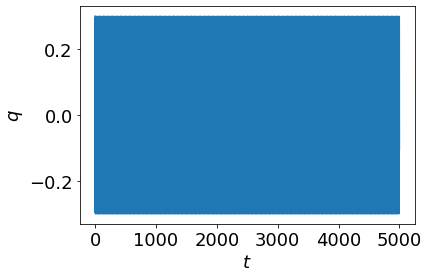

In [13]:
#plot
plt.plot(t,trj[0])
plt.xlabel('$t$')
plt.ylabel('$q$')
#plt.savefig('trajectory.pdf',bbox_inches='tight')

## Reference trajectory

In [14]:
# reference trajectory
# with Leapfrog and n_h intermediate steps
# Pre-computed data trj_ref is loaded above. Uncomment all lines below for re-computation

#trj_ref=jnp.zeros((2*gpmp.dim,n+1))
#trj_ref = ops.index_update(trj_ref,ops.index[:gpmp.dim,0],q0)
#solp0LP = lambda p0: LP(jnp.hstack([q0,p0]),n_h,h,f)[:gpmp.dim]-trj[:,1]

#p0 = NewtonLAX(solp0LP,jnp.zeros(gpmp.dim)) # get the right p to initialise reference (should approximate q0dot up to trunc. error in L)
#trj_ref = ops.index_update(trj_ref,ops.index[gpmp.dim:,0],p0)
#trj_ref = lax.fori_loop(0,n,lambda j,trj_ref: ops.index_update(trj_ref,ops.index[:,j+1], LP(trj_ref[:,j],n_h,h,f) ),trj_ref)

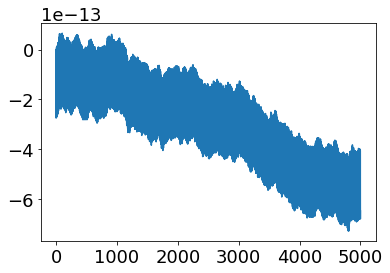

In [15]:
# check conservation properties of reference solution on exact energy (sanity check)
plt.plot(t,H_ref(trj_ref)-H_ref(trj_ref[:,0]))

## comparision

In [16]:
# difference LSI prediction and reference in absolute norm and discrete l2-norm
jnp.amax(jnp.abs((trj_ref[0]-trj).flatten())),jnp.sqrt(jnp.sum(((trj_ref[0]-trj).flatten())**2))/n

(DeviceArray(0.00049091, dtype=float64),
 DeviceArray(1.76154457e-06, dtype=float64))

Text(0, 0.5, '$q$')

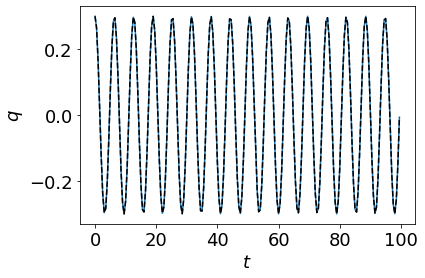

In [17]:
# compare reference and LSI prediction up to index id_max
id_max=200
plt.plot(t[:id_max],trj[0,:id_max],'-',t[:id_max],trj_ref[0,:id_max],'k--')
plt.xlabel('$t$')
plt.ylabel('$q$')
#plt.savefig('CompareToRef_timeplot200.pdf',bbox_inches='tight')

## compute derivatives with Lagrangian framework

In [18]:
qdotRectrj = trj_phase[1].reshape(trj.shape) # using pre-computed data
#qdotRectrj=gpmp.motionqdot(trj)             # uncomment for re-computation

Text(0.5, 0, '$\\dot{q}$')

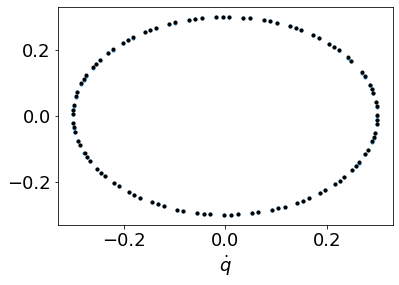

In [19]:
# (q,q') phase plot of LSI prediction and reference until index id_max
id_max=100
plt.plot(trj[0,:id_max],qdotRectrj[0,:id_max],'.',trj_ref[0,:id_max],trj_ref[1,:id_max],'k.')
plt.xlabel('$q$')
plt.xlabel('$\dot{q}$')
#plt.savefig('PendulumTrajectoryPhase100.pdf',bbox_inches='tight')

Text(0, 0.5, '$H_{\\mathrm{ref}}  - {H_{\\mathrm{ref}}}_0$')

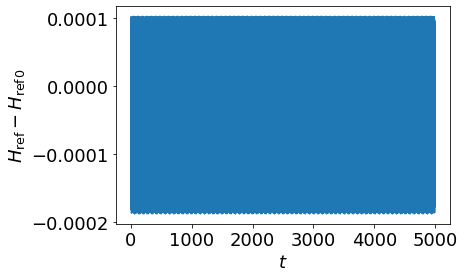

In [20]:
# plt exact energy along motion
plt.plot(t,H_ref(trj_phase)-H_ref(trj_phase[:,0]))
plt.xlabel('$t$')
plt.ylabel('$H_{\mathrm{ref}}  - {H_{\mathrm{ref}}}_0$')
#plt.savefig('PendulumConservationHref.pdf',bbox_inches='tight')

In [21]:
# prepare data for storage
trj_phase=jnp.vstack([trj,qdotRectrj])

## Detection of conserved energy from LSI framework

In [22]:
# The LSI framework identifies a conserved quantity
# Evaluate truncations of the conserved quantity H along the computed trajectory

H2_trj = jnp.zeros(n+1)
H0_trj = jnp.zeros(n+1)

for j1 in tqdm(range(n+1)):
    
        
    H2,H0 = gpmp.Hamiltonian(trj_phase[:,j1],nargout=2)

    H2_trj = ops.index_update(H2_trj ,ops.index[j1], H2[0] )
    H0_trj = ops.index_update(H0_trj ,ops.index[j1], H0 )



  0%|          | 0/10001 [00:00<?, ?it/s]

compiling Hamiltonian expression
Compiling Lrec2 (or a derivative)
Compiling Lrec2 (or a derivative)


100%|██████████| 10001/10001 [01:12<00:00, 137.91it/s]


Text(0, 0.5, '$H^{[2]}$')

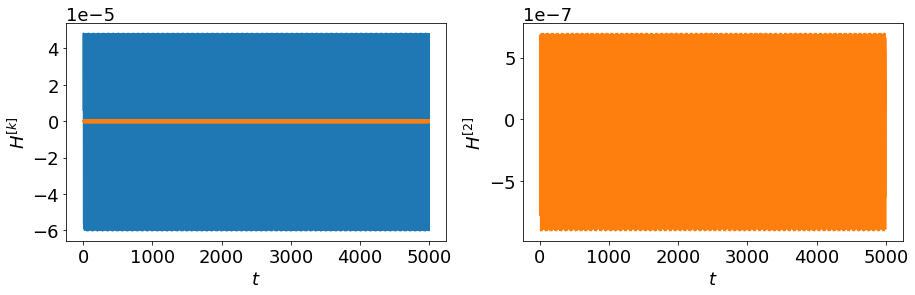

In [23]:
# plot truncations of the conserved quantity H along the computed trajectory
# This shows that H^[[2]] can be used for backward error analysis

fig, axs = plt.subplots(1,2,figsize=(15,4))

axs[0].plot(t,H0_trj-jnp.mean(H0_trj),t,H2_trj-jnp.mean(H2_trj))
axs[1].plot(t,H2_trj-jnp.mean(H2_trj),'C1')

axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$H^{[k]}$')
axs[1].set_xlabel('$t$')
axs[1].set_ylabel('$H^{[2]}$')
#plt.savefig('PendulumConservationHRecoveryAlongComputedMotion.pdf',bbox_inches='tight')

In [24]:
# save data
#pickle.dump( [trj,trj_phase,H2_trj,trj_ref], open( "data/PendulumMP10000_save.p", "wb" ) )

## Identification phase portrait 

The Hamiltonian is defined up to scaling and constant summands by the dynamical data (q's only).
The symplectic structure (pulled back to (q,q') tangent bundle over state space) is defined up to scaling by the dynamical data (q's only)

In [25]:
# evaluate truncations of the identified Hamiltonian on mesh in (q,q') phase space

nn = (30,30) # mesh points
spc = ((-1.2,1.2),(-.6,.6)) # q range, q' range

qq    = jnp.linspace(spc[0][0],spc[0][1],nn[0])
qqdot = jnp.linspace(spc[1][0],spc[1][1],nn[1])

In [26]:
# computation of truncations of the identified Hamiltonian on mesh in (q,q') phase space

HVal2 = jnp.zeros(nn)
HVal0 = jnp.zeros(nn)

for j1 in tqdm(range(nn[0])):
    for j2 in range(nn[1]):
        
        H2,H0 = gpmp.Hamiltonian(jnp.array([qq[j1],qqdot[j2]]),nargout=2)
        
        HVal2 = ops.index_update(HVal2,ops.index[j1,j2], H2[0] )
        HVal0 = ops.index_update(HVal0,ops.index[j1,j2], H0 )
            

100%|██████████| 30/30 [00:09<00:00,  3.07it/s]


In [27]:
# compute reference
[qqq,qqqdot]=jnp.meshgrid(qq,qqdot)
HVal_ref=1/2*qqqdot**2 - jnp.cos(qqq)

Text(0, 0.5, '$\\dot{q}$')

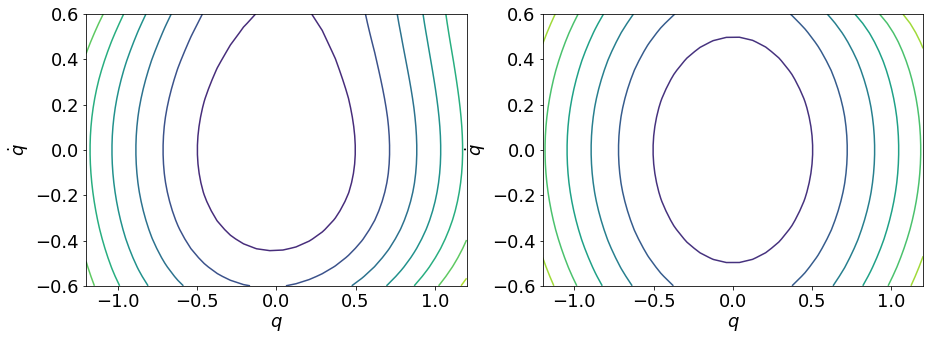

In [28]:
# contour plot of zeroth and 2nd truncation of recovered energies

fig, axs = plt.subplots(1,2,figsize=(15,5))

ct0=axs[0].contour(qqq,qqqdot,HVal0.transpose())
axs[0].set_xlabel('$q$')
axs[0].set_ylabel('$\dot{q}$')

ct2=axs[1].contour(qqq,qqqdot,HVal2.transpose())
axs[1].set_xlabel('$q$')
axs[1].set_ylabel('$\dot{q}$')


In [29]:
# compare two 2d contour plots (q,qdot) visually
# this generates an overlay of a contour plot ct with the contour plot of the reference solution

def compare_contour(ct,ax):
    collect_Href = jnp.array([])
    for j in range(1,len(ct.collections)):
        col = ct.collections[j].get_paths()
        for i in range(0,len(col)):
            pth=col[i].vertices
            collect_Href = jnp.append(collect_Href,H_ref(pth[-1]))
            ax.plot(pth[:,0],pth[:,1])
    # compare contours
    
    ctr=ax.contour(qqq,qqqdot,HVal_ref,colors=['black'],levels=collect_Href.sort(),linestyles='dashed')
    for c in ctr.collections:
        c.set_dashes([(0, (1.0, 4.0))])
    ax.set_xlabel('$q$')
    ax.set_ylabel('$\dot{q}$')
    
    return ctr

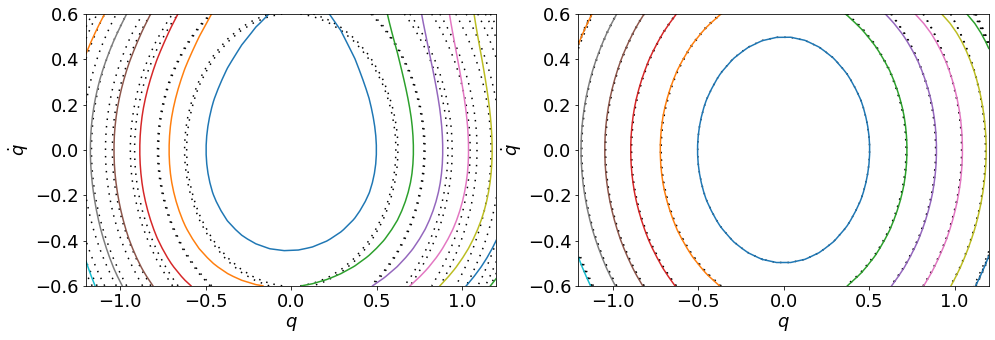

In [30]:
fig = plt.figure(figsize=(25,5))
ax1 = fig.add_subplot(131)
compare_contour(ct0,ax1)
ax2 = fig.add_subplot(132)
compare_contour(ct2,ax2)



In [31]:
# quantitatively compare level-set of uncorrected Hamiltonian to reference

err0=compare_contour_num(H_ref,lambda y: gpmp.Hamiltonian(y,nargout=2)[1],qq,qqdot)
err0=err0/(len(qq)*len(qqdot)) # normalise

  0%|          | 0/30 [00:00<?, ?it/s]

compiling Hamiltonian expression
Compiling Lrec2 (or a derivative)
Compiling Lrec2 (or a derivative)


100%|██████████| 30/30 [00:03<00:00,  9.25it/s]


In [32]:
# quantitatively compare level-set of 2nd order corrected Hamiltonian to reference

err2=compare_contour_num(H_ref,lambda y: gpmp.Hamiltonian(y,nargout=2)[0][0],qq,qqdot)
err2=err2/(len(qq)*len(qqdot)) # normalise

  0%|          | 0/30 [00:00<?, ?it/s]

compiling Hamiltonian expression
Compiling Lrec2 (or a derivative)
Compiling Lrec2 (or a derivative)


100%|██████████| 30/30 [00:05<00:00,  5.54it/s]


In [33]:
# error of zeroth and 2nd order truncation of identified energy
err0,err2

(DeviceArray(0.10192195, dtype=float64),
 DeviceArray(0.01044264, dtype=float64))

## Comparision to learning flow map data (no structure)

### Approximate velocities using finite differences and fit GP to approximated flow map data

In [34]:
dim = int(data.shape[0]/2) # dimension of state space

### forward finite-differences

In [35]:
# train 2d GP flow map using forward differences to approximate velocities
velocitiesFD = 1/h*jnp.array([gpmp.DataTriples[:,0,1]-gpmp.DataTriples[:,0,0],gpmp.DataTriples[:,0,2]-gpmp.DataTriples[:,0,1]]).transpose()
train_in  = jnp.vstack([gpmp.DataTriples[:,0,0],velocitiesFD[:,0]])
train_out = jnp.vstack([gpmp.DataTriples[:,0,1],velocitiesFD[:,1]])

In [36]:
# Fit GP to data with scaled RBF kernel, using ML estimation of the parameters
kernel = C(2.277, (1., 3.)) * RBF(1.7, (1.65, 3.)) # scaled RBF kernel
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0,random_state=101)
gp.fit(train_in.T,train_out.T)

GaussianProcessRegressor(kernel=1.51**2 * RBF(length_scale=1.7),
                         random_state=101)

In [37]:
# compute prediction of trajectory based on the learned flow map
def pred_trj(gp,NSci):
    
    trjSci = jnp.zeros((trj.shape[0]*2,NSci))
    trjSci = ops.index_update(trjSci,ops.index[:,0],jnp.array([q0,q0dot]).flatten())
    
    for j in tqdm(range(0,trjSci.shape[1]-1)):
        trjSci = ops.index_update(trjSci,ops.index[:,j+1],gp.predict(trjSci[:,j].reshape(1,-1))[0])
    
    return trjSci

In [38]:
trjSciFD=pred_trj(gp,n)

100%|██████████| 9999/9999 [00:42<00:00, 234.67it/s]


Text(0, 0.5, '$\\dot{q}$')

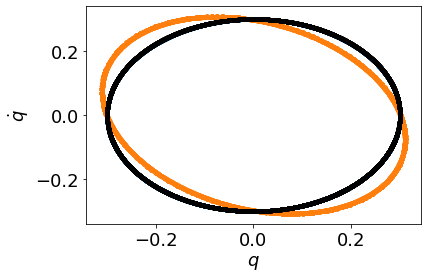

In [39]:
# compare LSI, GP with forward differences and reference trajectory
plt.plot(trj[0],qdotRectrj[0],'C0.',trjSciFD[0,:n],trjSciFD[1,:n],'C1.',trj_ref[0],trj_ref[1],'k.')

plt.xlabel('$q$')
plt.ylabel('$\dot{q}$')
#plt.savefig('PendulumMotionLGP_forwd_diff_vsShadow.pdf',bbox_inches='tight')

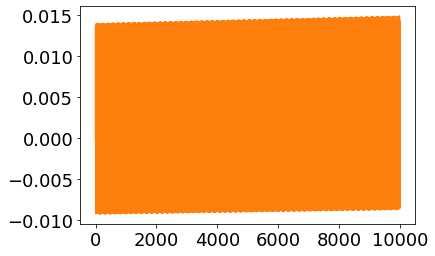

In [40]:
# plot exact energy along GP trajectory
plt.plot(H_ref(trjSciFD)-H_ref(trjSciFD[:,0]),'C1')

### central finite-differences

In [41]:
# central difference approximation of velocity data
velocitiesCFD=(data[:dim,:,2:]-data[:dim,:,:-2])/(2*h)
dataCFD=jnp.vstack([data[:dim,:,1:-1],velocitiesCFD])
train_in =dataCFD[:,:,:-1].reshape(2*dim,dataCFD[:,:,:-1].shape[1]*dataCFD[:,:,:-1].shape[2])
train_out=dataCFD[:,:,1:].reshape(2*dim,dataCFD[:,:,1:].shape[1]*dataCFD[:,:,1:].shape[2])

In [42]:
# Fit GP to data with scaled RBF kernel, using ML estimation of the parameters
kernel = C(2.277, (2., 3.)) * RBF(1.7, (1.65, 1.75)) # scaled RBF kernel
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0,random_state=101)
gp.fit(train_in.T,train_out.T)

GaussianProcessRegressor(kernel=1.51**2 * RBF(length_scale=1.7),
                         random_state=101)

In [43]:
# compute trajectory using the learned GP based of central difference approximations of velocities
trjSciCFD=pred_trj(gp,n)

100%|██████████| 9999/9999 [00:43<00:00, 232.12it/s]


Text(0, 0.5, '$\\dot{q}$')

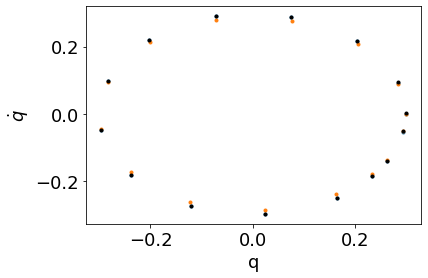

In [44]:
# plot LSI, GP with central differences, and reference trajectories' snapshot data

mx_indx = 15 # number of snapshots

plt.plot(trj[0,:mx_indx],qdotRectrj[0,:mx_indx],'C0.',trjSciCFD[0,:mx_indx],trjSciCFD[1,:mx_indx],'C1.',trj_ref[0,:mx_indx],trj_ref[1,:mx_indx],'k.')
plt.xlabel('q')
plt.ylabel('$\dot{q}$')
#plt.savefig('PendulumMotionGP_central_FD_vsShadow15Pts.pdf',bbox_inches='tight')

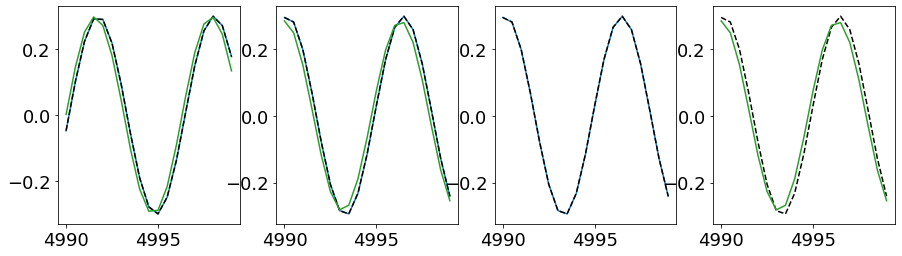

In [45]:
# comparision of phase of LSI, GP with central differences, and reference trajectories'
id_mn = 9980 # first snapshot index
id_mx = 9999 # final snapshot index
_, axs = plt.subplots(1,4,figsize=(15,4))
axs[0].plot(t[id_mn:id_mx],trj[0,id_mn:id_mx],'C0',t[id_mn:id_mx],trj_ref[0,id_mn:id_mx],'k--',t[id_mn:id_mx],trjSciCFD[0,id_mn:id_mx],'C2')
axs[1].plot(t[id_mn:id_mx],qdotRectrj[0,id_mn:id_mx],'C0',t[id_mn:id_mx],trj_ref[1,id_mn:id_mx],'k--',t[id_mn:id_mx],trjSciCFD[1,id_mn:id_mx],'C2')
axs[2].plot(t[id_mn:id_mx],qdotRectrj[0,id_mn:id_mx],'C0',t[id_mn:id_mx],trj_ref[1,id_mn:id_mx],'k--')
axs[3].plot(t[id_mn:id_mx],trj_ref[1,id_mn:id_mx],'k--',t[id_mn:id_mx],trjSciCFD[1,id_mn:id_mx],'C2')

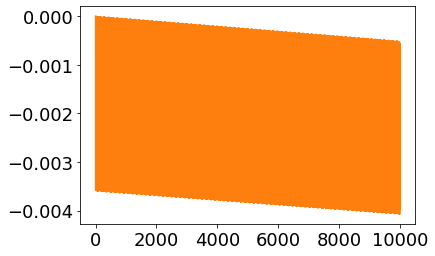

In [46]:
# energy plot
plt.plot(H_ref(trjSciCFD)-H_ref(trjSciCFD[:,0]),'C1')

# Lagrangian GPs

## using central-difference derivatives for training and analytically computed training data, for comparision

In [47]:
# approximate first and second derivatives using central finite differences
# requirement: trajectory observations contain at least 5 consecutive points

# velocities
velocitiesCFD=(data[:dim,:,2:]-data[:dim,:,:-2])/(2*h)
dataCFD=jnp.vstack([data[:dim,:,1:-1],velocitiesCFD])

# acceleration
accCFD=(dataCFD[dim:,:,2:]-dataCFD[dim:,:,:-2])/(2*h)
dataCFD2 = jnp.vstack([data[:dim,:,2:-2],velocitiesCFD[:dim,:,1:-1],accCFD])
ELdataCFD = dataCFD2.reshape((3,dataCFD2.shape[1]*dataCFD2.shape[2]))

In [48]:
# number of training data with position, velocities, and acceleration
ELdataCFD.shape[-1]

800

In [49]:
# for comparison, train with exact derivative data as well
# generation of training data

# q values from original training set
data_q    = data[0].flatten()

# qdot values computed 1-dimensional Halton sequence
halton = Halton()
data_vel=jnp.array(halton.generate(Space([(spacedim[1][0],spacedim[1][1])]),data_q.shape[0])).transpose()[0]

# accelaration data analytically computed
data_acc = -jnp.sin(data_q)

# collect training data
ELdataExact = jnp.vstack([data_q,data_vel,data_acc])

In [50]:
# create instance of learned Lagrangian for training data with approximated velocities and accelleraions and for analytically computed training data
gpel    = GPEL(k,h,ELdataCFD)     # training data computed using central finite differences
gpel_ex = GPEL(k,h,ELdataExact)   # process with analytically computed training data

In [51]:
# train both processes. Set scaling factor (symplectic volume of unit cube) to 100
_= gpel.train(sympl_std_vol=100)
_= gpel_ex.train(sympl_std_vol=100)

compute data consistency equations and non-triviality conditions
solve linear system dimensions: (802, 800)
compute data consistency equations and non-triviality conditions
solve linear system dimensions: (2402, 2400)


In [52]:
# check residuum and rank of solution of linear system solved during training
gpel.res,gpel.rank,gpel_ex.res,gpel_ex.rank

(DeviceArray([5.90980166e-06], dtype=float64),
 DeviceArray(59, dtype=int64),
 DeviceArray([3.2285708e-06], dtype=float64),
 DeviceArray(62, dtype=int64))

In [53]:
# create instances of integrators
gpelInt=VarMPIntegrator(h,gpel.L)      # create variational integrator using the midpoint rule for the learned Lagrangian gpel.L
gpelIntEx=VarMPIntegrator(h,gpel_ex.L) # create variational integrator using the midpoint rule for the learned Lagrangian gpel_ex.L

In [54]:
# compute trajectories and velocities using the two learned Lagrangians gpel.L and gpel_ex.L

# load pre-computed data
trjGPEL,velGPEL,pGPEL,trjGPEL_ex,velGPEL_ex,pGPEL_ex=pickle.load(open('data/Pendulum_GPEL_data_10000.p','rb'))

# uncomment the following cells for re-computation

In [55]:
#trjGPEL=gpelInt.motion(q0,q0dot,n) # compute motion

In [56]:
#velGPEL,pGPEL = gpelInt.velocities(trjGPEL) # compute corresponding velocities using the Lagrangian framework

In [57]:
#trjGPEL_ex=gpelIntEx.motion(q0,q0dot,n) # compute motion

In [58]:
#velGPEL_ex,pGPEL_ex = gpelIntEx.velocities(trjGPEL_ex) # compute corresponding velocities using the Lagrangian framework

In [59]:
#pickle.dump([trjGPEL,velGPEL,pGPEL,trjGPEL_ex,velGPEL_ex,pGPEL_ex],open('data/Pendulum_GPEL_data_10000.p','wb')) # save data

Text(0, 0.5, '$\\dot{q}$')

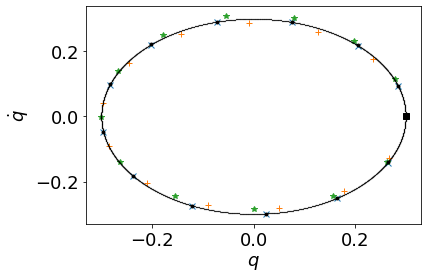

In [60]:
# plot shapshot data of trajectories of the two Lagrangians together with LSI trajectory and reference trajectory

mx = 13      # number of snapshots
mx2 = 10000  # number of snapshots of reference

f=plt.figure()
ax=f.add_subplot(111)
ax.plot(trj[0,:mx],qdotRectrj[0,:mx],'x')        # Shadow integration (blue) - all discretisation errors corrected up to second order in h 
ax.plot(trjGPEL[0,:mx],velGPEL[0,:mx],'+')       # contains discretisation error at training and simulation (orange)
ax.plot(trjGPEL_ex[0,:mx],velGPEL_ex[0,:mx],'*') # contains discretisation error only at simulation (green)
ax.plot(trj_ref[0,0],trj_ref[1,0],'ks')          # reference start
ax.plot(trj_ref[0,:mx],trj_ref[1,:mx],marker='.',color='k',alpha=0.9,linestyle='none')  # reference
ax.plot(trj_ref[0,:mx2],trj_ref[1,:mx2],'k.',alpha=1,linestyle='none',markersize=.1)  # reference

plt.xlabel('$q$')
plt.ylabel('$\dot{q}$')
#plt.savefig('PendulumMotionLGP_central_FD_vs_exact_vsShadow13Pts.pdf',bbox_inches='tight')

In [61]:
# energies computed using the learned Lagrangians (no correction)

HamGPEL=gpelInt.Hamiltonian(trjGPEL,velGPEL,pGPEL)
HamGPEL_ex=gpelIntEx.Hamiltonian(trjGPEL_ex,velGPEL_ex,pGPEL_ex)

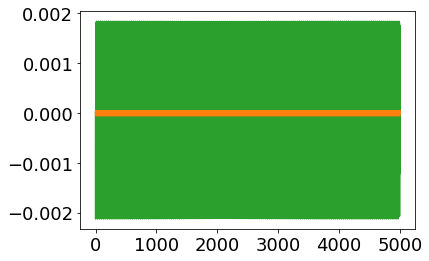

In [62]:
plt.plot(t[:-1],HamGPEL_ex-HamGPEL_ex[0],'C2')             # only discretisation error when simulating
plt.plot(t[:-1],HamGPEL-HamGPEL[0],'C1')                   # Double discretisation errors. However, these compensate

In [63]:
# organsie data
xtrj = jnp.array([trjGPEL[0],velGPEL[0]])
xtrj_ex = jnp.array([trjGPEL_ex[0],velGPEL_ex[0]])

Text(0, 0.5, '$H_{ref}$')

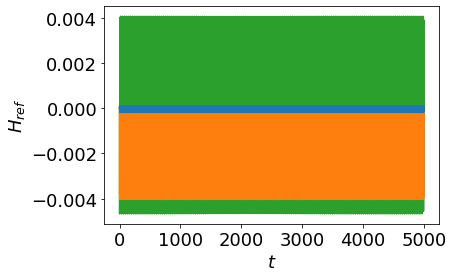

In [64]:
# Energy behaviour along computed motions of LSI, LGP and LGPexact using the reference Hamiltonian

plt.plot(t[:-1],H_ref(xtrj_ex)-H_ref(xtrj_ex)[0],color='C2')

plt.plot(t[:-1],H_ref(xtrj)-H_ref(xtrj)[0],'C1')
plt.plot(t,H_ref(trj_phase)-H_ref(trj_phase[:,0]),'C0')
plt.xlabel('$t$')
plt.ylabel('$H_{ref}$')
#plt.savefig('PendulumEnergyLGP_LGPExact_LSI.pdf',bbox_inches='tight')

### Identification of phase portraits using the Lagrangian learned based on central difference data

In [65]:
# computed learned Hamiltonian over mesh
HValGPEL = jnp.zeros(nn)

for j1 in tqdm(range(nn[0])):
    for j2 in range(nn[1]):
        HValGPEL = ops.index_update(HValGPEL,ops.index[j1,j2], gpel.HamiltonianJet(jnp.hstack([qq[j1],qqdot[j2]])) )
        

100%|██████████| 30/30 [00:05<00:00,  5.13it/s]


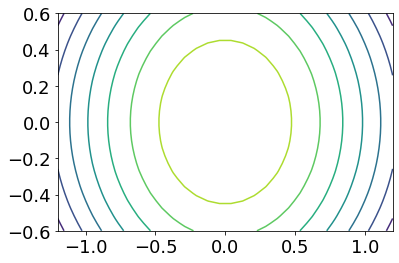

In [66]:
# learned Hamiltonian over mesh
ctGPEL=plt.contour(qq,qqdot,HValGPEL.transpose(),levels = 10)

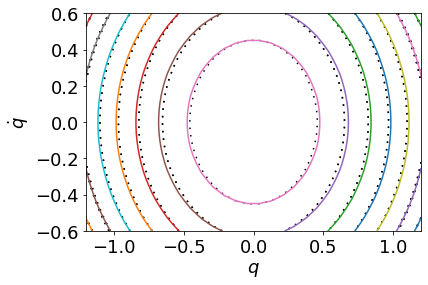

In [67]:
# comparision to reference
fGPEL = plt.figure()
aGPEL=fGPEL.add_subplot(1,1,1)
compare_contour(ctGPEL,aGPEL)

In [68]:
# quantitative difference of contours
errGPEL=compare_contour_num(H_ref,gpel.HamiltonianJet,qq,qqdot)
errGPEL=errGPEL/(len(qq)*len(qqdot)) # normalise

100%|██████████| 30/30 [00:00<00:00, 31.04it/s]


In [69]:
errGPEL

DeviceArray(0.02611084, dtype=float64)

### Identification of phase portraits using the Lagrangian learned based on exact training data

In [70]:
# compute learned Hamiltonian over mesh
HValGPEL_ex = jnp.zeros(nn)

for j1 in tqdm(range(nn[0])):
    for j2 in range(nn[1]):
        HValGPEL_ex = ops.index_update(HValGPEL_ex,ops.index[j1,j2], gpel_ex.HamiltonianJet(jnp.hstack([qq[j1],qqdot[j2]])) )
        

100%|██████████| 30/30 [00:05<00:00,  5.21it/s]


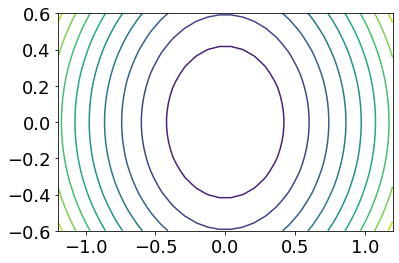

In [71]:
ctGPEL_ex=plt.contour(qq,qqdot,HValGPEL_ex.transpose(),levels = 10)

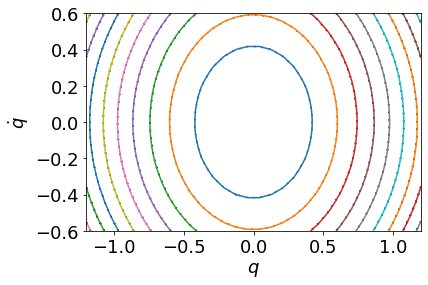

In [72]:
# comparison to reference energy
fGPEL_ex = plt.figure()
aGPEL_ex=fGPEL_ex.add_subplot(1,1,1)
compare_contour(ctGPEL_ex,aGPEL_ex)

In [73]:
# quantitative difference of level sets to reference
errGPEL_ex=compare_contour_num(H_ref,gpel_ex.HamiltonianJet,qq,qqdot)
errGPEL_ex=errGPEL_ex/(len(qq)*len(qqdot)) # normalise

100%|██████████| 30/30 [00:01<00:00, 26.93it/s]


In [74]:
errGPEL_ex

DeviceArray(3.40859097e-05, dtype=float64)